### Initialize Dataset

In [1]:
SPLITTED_DATASET = "DATASET"
train_dir = "DATASET/train"
test_dir  = "DATASET/test"

train_dir,test_dir

('DATASET/train', 'DATASET/test')

#### Visualize train_dir, test_dir

Random image path: DATASET\train\D\K_D (32).jpeg
Image class: D
Image height: 400
Image width: 400


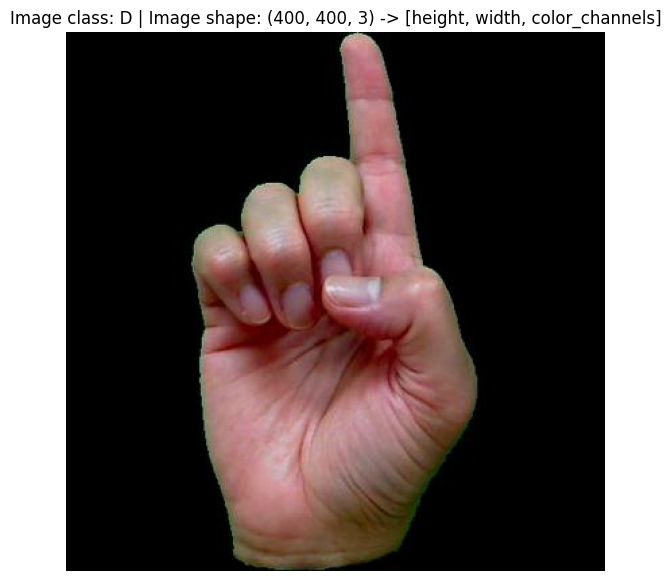

In [2]:
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set seed
# random.seed(30) # <- try changing this and see what happens
SPLITTED_DATASET = "DATASET"

# Convert SAVE_DATASET_PATH to a Path object
save_dataset_path = Path(SPLITTED_DATASET)

# 1. Get all image paths (* means "any combination")
image_extensions = ["*.jpg", "*.jpeg", "*.JPG", "*.png", "*.PNG"]
image_path_list = []

for ext in image_extensions:
    image_path_list.extend(save_dataset_path.rglob(ext))

# Check if the list is empty
if not image_path_list:
    print("No images found in the specified path.")
else:
    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}") 
    print(f"Image width: {img.width}")
    # img.show()  # Display the image

    # Turn the image into an array
    img_as_array = np.asarray(img)

    # Plot the image with matplotlib
    plt.figure(figsize=(10, 7))
    plt.imshow(img_as_array)
    plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
    plt.axis(False);

#### Visualize transformed images

In [3]:
import random
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    # random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Random image path: DATASET\test\J\C_J (12).jpg
Image class: J
Image height: 480
Image width: 640


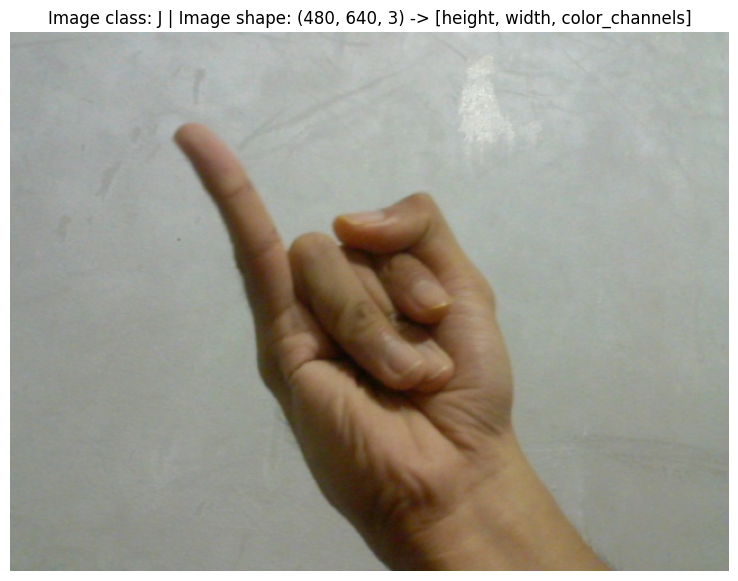

#### Load the model & Transforms

In [4]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchinfo import summary


weights = models.MobileNet_V2_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
plot_transformed_images(image_path_list, 
                        transform=auto_transforms, 
                        n=3)

In [6]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=auto_transforms)

In [7]:
# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 6 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1ca1d4f0970>,
 <torch.utils.data.dataloader.DataLoader at 0x1ca1d4f0a90>)

In [ ]:
class_names = train_data.classes
class_names

In [9]:
len_class_names = len(class_names)
len_class_names

35

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ASL_mobilenet = models.mobilenet_v2(weights=weights).to(device)
ASL_mobilenet

In [ ]:
from torchinfo import summary

summary(model=ASL_mobilenet, 
        input_size=(len_class_names, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

#### Freese the base layer

In [34]:
for param in ASL_mobilenet.features.parameters():
    param.requires_grad = False

In [35]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
ASL_mobilenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
summary(ASL_mobilenet, 
        input_size=(len_class_names, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

#### Try forward pass to a single image

In [37]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
ASL_mobilenet.eval()
with torch.inference_mode():
    pred = ASL_mobilenet(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[ 0.0970, -0.0860, -0.0401,  0.1488, -0.0559, -0.1340, -0.0580, -0.0766,
          0.0502,  0.1196,  0.0740,  0.0971, -0.2617,  0.2303, -0.3337, -0.2027,
          0.1131,  0.2628,  0.0030,  0.1065,  0.2040, -0.2761,  0.1095, -0.0651,
         -0.1647, -0.0532, -0.0252, -0.2696, -0.1917,  0.1388,  0.1118,  0.0742,
          0.1220, -0.0875,  0.1048]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0313, 0.0261, 0.0273, 0.0330, 0.0269, 0.0249, 0.0268, 0.0263, 0.0299,
         0.0320, 0.0306, 0.0313, 0.0219, 0.0358, 0.0204, 0.0232, 0.0318, 0.0370,
         0.0285, 0.0316, 0.0349, 0.0216, 0.0317, 0.0266, 0.0241, 0.0269, 0.0277,
         0.0217, 0.0235, 0.0327, 0.0318, 0.0306, 0.0321, 0.0260, 0.0316]],
       device='cuda:0')

Output prediction label:
tensor([17], device='cuda:0')

Actual label:
23


#### Create train & test loop functions

##### Train

In [42]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

##### Test

In [43]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### Creating a train() function to combine train_step() and test_step()

In [44]:
from tqdm.auto import tqdm
import copy
import time

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler, patience):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_loss_accuracy = np.inf
    best_test_accuracy = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stopping_counter = 0
    since = time.time()
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        model.eval()
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        
        if scheduler:
            scheduler.step(test_loss)
            
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | lr: {current_lr:.6f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
        
        if test_loss < best_loss_accuracy:
            best_loss_accuracy = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
            
        else:
            early_stopping_counter += 1
            print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
            if early_stopping_counter >= patience:
                print('Early stopping triggered.')
                model.load_state_dict(best_model_wts)
                time_elapsed = time.time() - since
                print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                break
    
    # Load the best model weights before returning results
    model.load_state_dict(best_model_wts)
    return results

#### Train and Evaluate mobilenetv2

In [45]:
from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch import nn
from torch.optim import Adam

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 64
EARLY_STOPPING_PATIENCE = 5  # Number of epochs to wait for improvement before stopping


ASL_mobilenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=ASL_mobilenet.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train mobilenetv2
mobilenetv2_result = train(
                    model=ASL_mobilenet,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    scheduler=scheduler,
                    patience=EARLY_STOPPING_PATIENCE
                )

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
torch.save(ASL_mobilenet.state_dict(), "models/nums_alphs_35_mobilenetv2.pth")

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8684 | train_acc: 0.3913 | test_loss: 2.1413 | test_acc: 0.7319 | lr: 0.001000
Epoch: 2 | train_loss: 1.7409 | train_acc: 0.7946 | test_loss: 1.4163 | test_acc: 0.8304 | lr: 0.001000
Epoch: 3 | train_loss: 1.1769 | train_acc: 0.8852 | test_loss: 1.0481 | test_acc: 0.8719 | lr: 0.001000
Epoch: 4 | train_loss: 0.8665 | train_acc: 0.9282 | test_loss: 0.8238 | test_acc: 0.8969 | lr: 0.001000
Epoch: 5 | train_loss: 0.6896 | train_acc: 0.9408 | test_loss: 0.6633 | test_acc: 0.9174 | lr: 0.001000
Epoch: 6 | train_loss: 0.5572 | train_acc: 0.9567 | test_loss: 0.5782 | test_acc: 0.9235 | lr: 0.001000
Epoch: 7 | train_loss: 0.4712 | train_acc: 0.9613 | test_loss: 0.5269 | test_acc: 0.9253 | lr: 0.001000
Epoch: 8 | train_loss: 0.4038 | train_acc: 0.9700 | test_loss: 0.4548 | test_acc: 0.9379 | lr: 0.001000
Epoch: 9 | train_loss: 0.3474 | train_acc: 0.9733 | test_loss: 0.3996 | test_acc: 0.9451 | lr: 0.001000
Epoch: 10 | train_loss: 0.3050 | train_acc: 0.9761 | test_loss: 

#### Plot Curves

In [16]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

#### Load the Model

In [24]:
import torch
from torchvision.models import mobilenet_v2

num_classes = 35
model = mobilenet_v2(weights=None)
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
state_dict = torch.load("models/nums_alphs_35_mobilenetv2.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

#### Multilple Image Prediciton in test dir

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

# Ensure reproducibility
# random.seed(42)

# Randomly select test samples and labels
random_indices = random.sample(range(len(test_data)), k=9)  # Adjust k as needed for the number of samples
test_samples = [test_data[i][0] for i in random_indices]  # Extract the samples
test_labels = [test_data[i][1] for i in random_indices]  # Extract the labels

# Make predictions
model.eval()
pred_classes = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for sample in test_samples:
        sample = torch.unsqueeze(sample, dim=0).to(device)  # Prepare sample
        pred_logit = model(sample)  # Forward pass
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # Get prediction probability
        pred_class = torch.argmax(pred_prob).item()  # Get predicted class
        pred_classes.append(pred_class)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.squeeze().permute(1, 2, 0))  # Adjust channel order if necessary

    # Find the prediction label (in text form, e.g., "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g., "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, color="g")  # Green text if correct
    else:
        plt.title(title_text, fontsize=10, color="r")  # Red text if wrong

    plt.axis('off')

plt.tight_layout()
plt.show()


#### Single Image Prediction

In [32]:
import torchvision

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
image_path_to_predict = r"D:\SignLanguage\ASL_DATASET\LETTERS_NUMS\U\C_U (16).jpg"

pred_and_plot_image(model=model,
                    image_path=image_path_to_predict,
                    class_names=class_names,
                    transform=auto_transforms,
                    device=device)

#### Model Eval

In [36]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            
            all_preds.extend(y_pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    return all_preds, all_targets


In [37]:
y_pred, y_true = evaluate_model(model, test_dataloader, device)


In [38]:
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)


Accuracy: 0.9743
Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       130
           2       0.98      0.98      0.98       130
           3       0.98      0.98      0.98       130
           4       0.91      0.97      0.94       130
           5       0.95      0.97      0.96       130
           6       0.91      0.93      0.92       130
           7       0.98      0.95      0.96       130
           8       0.94      0.90      0.92       130
           9       0.92      0.98      0.95       130
           A       0.96      0.98      0.97       130
           B       1.00      1.00      1.00       130
           C       0.96      1.00      0.98       130
           D       0.96      0.97      0.97       130
           E       0.98      0.98      0.98       130
           F       0.98      1.00      0.99       130
           G       1.00      1.00      1.00       130
           H       1.00      1.00      1.

#### Prep model for Android

#### Save for android

In [ ]:
import torch
import torchvision.models as models

OUT_FEATURES = 35
MODEL_PATH = "models/nums_alphs_35_mobilenetv2.pth"
MODEL_NAME = "mnetV2_35"

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=OUT_FEATURES)

model.load_state_dict(torch.load(MODEL_PATH))

model.eval()

example_input = torch.rand(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 pixels
traced_model = torch.jit.trace(model, example_input)

optimized_model = torch.utils.mobile_optimizer.optimize_for_mobile(traced_model)

optimized_model._save_for_lite_interpreter(f"models/{MODEL_NAME}.ptl")


In [47]:
import torch

lite_model = torch.jit.load(f"models/{MODEL_NAME}.ptl")

example_input = torch.rand(1, 3, 224, 224)  # Example input with the same size used for tracing
output = lite_model(example_input)

print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 35])
